# **Pizza-Sales-SQL-Project**

The goal of this project is to demonstrate knowledge of SQL by creating a database and executing SQL queries.<br>


Project plan:

1. Find data;
2. Clean the data;
3. Design the database schema;
4. Create the database;
5. Run SQL queries.

## About the Dataset
This dataset contain detailed information about pizza orders, including specifics about the pizza variants, quantities, pricing, dates, times, and categorization details.

1. **pizza_id**: A unique identifier assigned to each distinct pizza variant available for ordering.
2. **order_id**: A unique identifier for each order made, which links to multiple pizzas.
3. **pizza_name_id**: An identifier linking to a specific name of the pizza.
4. **quantity**: The number of units of a specific pizza variant ordered within an order.
5. **order_date**: The date when the order was placed.
6. **order_time**: The time when the order was placed.
7. **unit_price**: The cost of a single unit of the specific pizza variant.
8. **total_price**: The aggregated cost of all units of a specific pizza variant in an order.
9. **pizza_size**: Represents the size of the pizza (e.g., small, medium, large).
10. **pizza_category**: Indicates the category of the pizza, such as vegetarian, non-vegetarian, etc.
11. **pizza_ingredients**: Provides a list or description of the ingredients used in the pizza.
12. **pizza_name**: Specifies the name of the specific pizza variant ordered.

The data source: [link](https://www.kaggle.com/datasets/nextmillionaire/pizza-sales-dataset)

## Import Libraries

In [1]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


## Load the Data

In [ ]:
df = pd.read_csv(r'data\pizza_sales.csv')

df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4.0,2.0,ital_supr_l,1.0,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5.0,2.0,mexicana_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


## Data Cleaning

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Change column type to int32 for columns: 'pizza_id', 'order_id', 'quantity'
    df = df.astype({'pizza_id': 'int32', 'order_id': 'int32', 'quantity': 'int32'})
    # Drop duplicate rows across all columns
    df = df.drop(columns=['pizza_name_id'])
    df = df.drop_duplicates()  
    df = df.reset_index(drop=True)
    return df

df_clean = clean_data(df.copy())

In [ ]:
def convert_date(date_str):
    try:
        # Trying to convert dates from the 'dd-mm-yyyy' format
        return pd.to_datetime(date_str, format='%d-%m-%Y').strftime('%Y-%m-%d')
    except ValueError:
        # If it doesn't work, try the format 'm/d/yyyy'
        return pd.to_datetime(date_str, format='%m/%d/%Y').strftime('%Y-%m-%d')

df_clean['order_date'] = df_clean['order_date'].apply(convert_date)

df_clean.head()

,pizza_id,order_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


## Database

### Database Schema

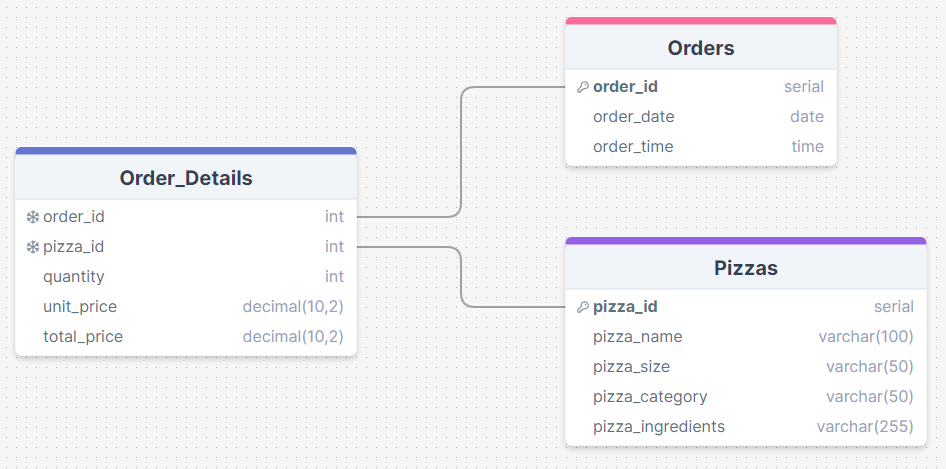

### Create the Database

In [ ]:
CREATE TABLE Orders (
    order_id SERIAL PRIMARY KEY,
    order_date DATE NOT NULL,
    order_time TIME NOT NULL
);

CREATE TABLE Pizzas (
    pizza_id SERIAL PRIMARY KEY,
    pizza_name VARCHAR(100) NOT NULL,
    pizza_size VARCHAR(50) NOT NULL,
    pizza_category VARCHAR(50) NOT NULL,
    pizza_ingredients VARCHAR(255) NOT NULL
);

CREATE TABLE Order_Details (
    order_id INTEGER REFERENCES Orders(order_id),
    pizza_id INTEGER REFERENCES Pizzas(pizza_id),
    quantity INTEGER NOT NULL,
    unit_price DECIMAL(10, 2) NOT NULL,
    total_price DECIMAL(10, 2) NOT NULL,
    PRIMARY KEY (order_id, pizza_id)
);

### Data Filling

In [ ]:
# Load environment variables from .env file
load_dotenv()

# Retrieving data from environment variables
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

orders_df = df_clean[['order_id', 'order_date', 'order_time']]
pizzas_df = df_clean[['pizza_id', 'pizza_name', 'pizza_size', 'pizza_category', 'pizza_ingredients']]
order_details_df = df_clean[['order_id', 'pizza_id', 'quantity', 'unit_price', 'total_price']]

In [ ]:
orders_df.to_sql('Orders', engine, if_exists='append', index=False)
pizzas_df.to_sql('Pizzas', engine, if_exists='append', index=False)
order_details_df.to_sql('Order_Details', engine, if_exists='append', index=False)

620

## Ad-hoc Analysis

### Average sales per day:

In [ ]:
SELECT 
    ROUND(AVG(subquery.daily_sales)::NUMERIC, 2) AS average_daily_sales
FROM (
    SELECT SUM(od.total_price) AS daily_sales
    FROM Order_details od
    JOIN Orders o ON od.order_id = o.order_id
    GROUP BY o.order_date
) AS subquery;

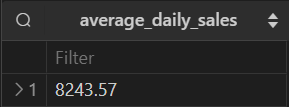

### Top 5 Best- and Worst-Selling Pizzas (by Quantity)

In [ ]:
WITH ranked_best AS (
    SELECT 
        pizza_name, 
        SUM(quantity) AS order_amount,
        ROW_NUMBER() OVER (ORDER BY SUM(quantity) DESC) AS rank
    FROM 
        Pizzas AS p
    JOIN 
        order_details AS od ON 
        od.pizza_id = p.pizza_id 
    GROUP BY 
        pizza_name
    ORDER BY 
        order_amount DESC
    LIMIT 5
),
ranked_worst AS (
    SELECT 
        pizza_name, 
        SUM(quantity) AS order_amount,
        ROW_NUMBER() OVER (ORDER BY SUM(quantity) ASC) AS rank
    FROM 
        Pizzas AS p
    JOIN 
        order_details AS od ON 
        od.pizza_id = p.pizza_id 
    GROUP BY 
        pizza_name
    ORDER BY 
        order_amount ASC
    LIMIT 5
)
SELECT 
    best.pizza_name AS best_pizza_name,
    best.order_amount AS best_order_amount,
    worst.pizza_name AS worst_pizza_name,
    worst.order_amount AS worst_order_amount
FROM 
    ranked_best best
FULL OUTER JOIN 
    ranked_worst worst ON
    best.rank = worst.rank
ORDER BY 
    best.rank;

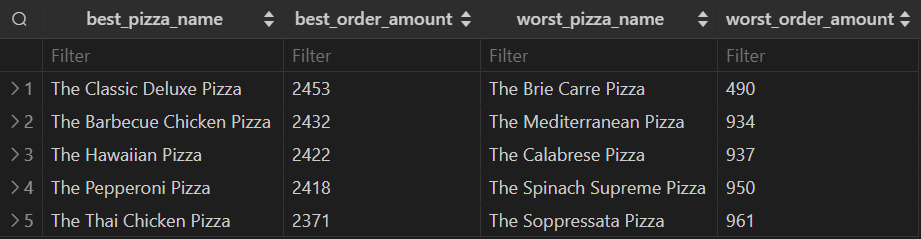

### Most Profitable Hours of the Day

In [ ]:
SELECT
    to_char(date_trunc('hour', (CURRENT_DATE + o.order_time::interval)), 'HH24:MI') AS hour_of_day,
    SUM(od.quantity) AS total_quantity,
    ROUND(AVG(SUM(od.quantity)) OVER()) AS avg_quantity,
    ROUND(SUM(od.total_price)) AS total_revenue,
    ROUND(AVG(SUM(od.total_price)) OVER()) AS avg_revenue
FROM 
    Orders AS o
JOIN 
    order_details od ON 
    od.order_id = o.order_id
GROUP BY 
    hour_of_day
ORDER BY 
    total_quantity DESC;

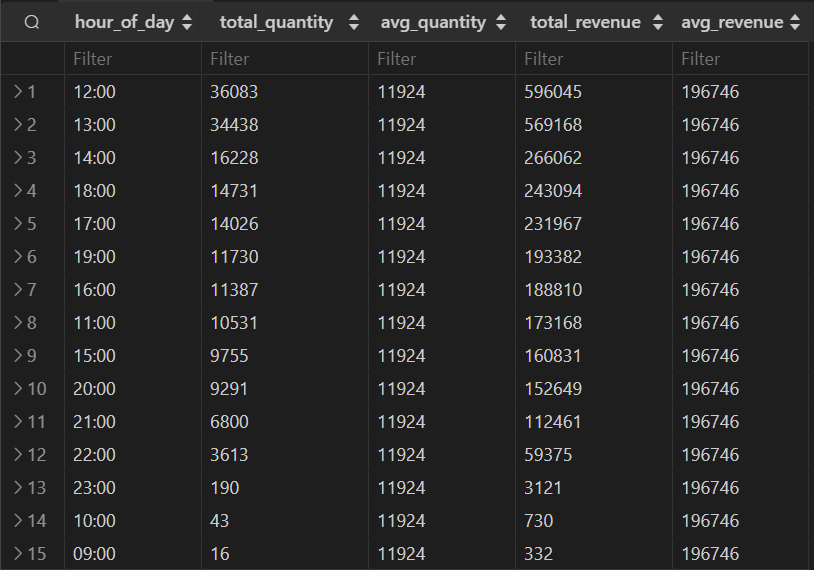
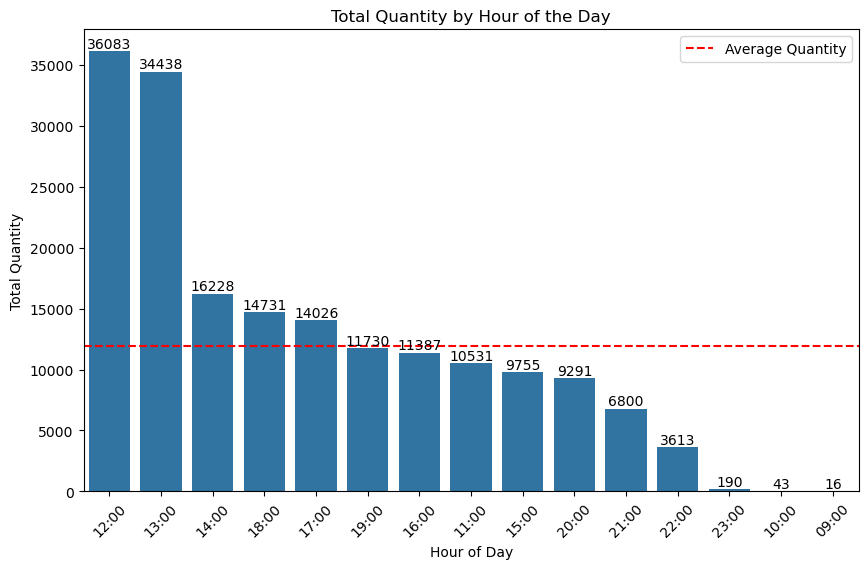

### Months with Orders Placed at 23:00, 10:00, and 09:00

In [ ]:
SELECT
    to_char(o.order_date::date, 'YYYY-MM') AS month,
    to_char(date_trunc('hour', (CURRENT_DATE + o.order_time::interval)), 'HH24:MI') AS hour_of_day,
    SUM(od.quantity) AS total_quantity
FROM 
    Orders AS o
JOIN 
    order_details od ON 
    od.order_id = o.order_id
WHERE 
    to_char(date_trunc('hour', (CURRENT_DATE + o.order_time::interval)), 'HH24:MI') IN ('23:00', '10:00', '09:00')
GROUP BY 
    month, hour_of_day
ORDER BY 
    month ASC, hour_of_day ASC;

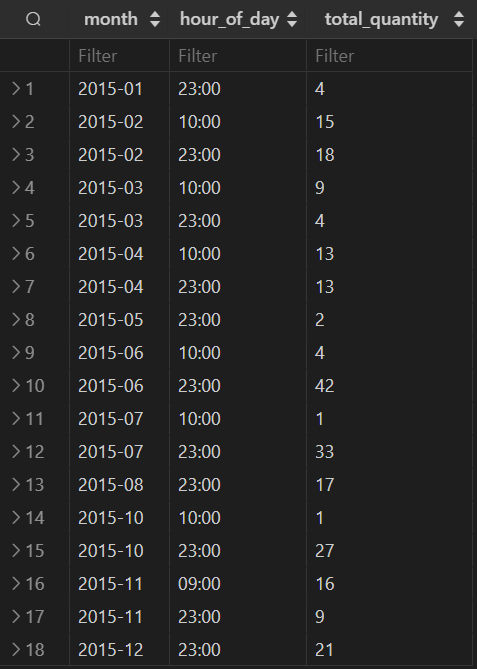
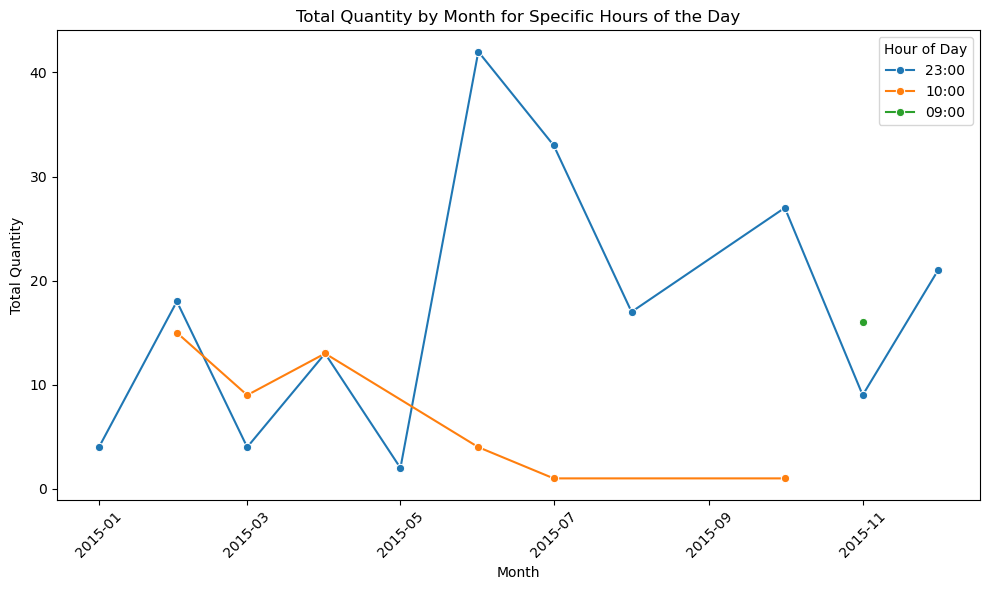

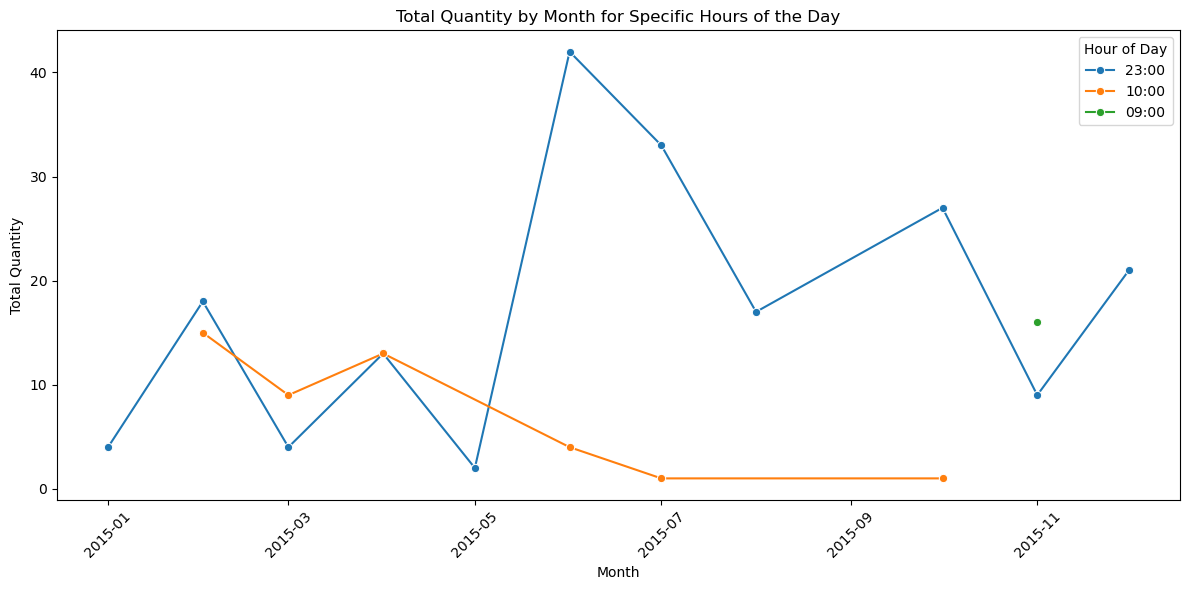

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data: month, hour_of_day, total_quantity
data = {
    'month': ['2015-01', '2015-02', '2015-02', '2015-03', '2015-03', '2015-04', '2015-04', '2015-05', '2015-06', '2015-06',
              '2015-07', '2015-07', '2015-08', '2015-10', '2015-10', '2015-11', '2015-11', '2015-12'],
    'hour_of_day': ['23:00', '10:00', '23:00', '10:00', '23:00', '10:00', '23:00', '23:00', '10:00', '23:00',
                    '10:00', '23:00', '23:00', '10:00', '23:00', '09:00', '23:00', '23:00'],
    'total_quantity': [4, 15, 18, 9, 4, 13, 13, 2, 4, 42, 1, 33, 17, 1, 27, 16, 9, 21]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Convert month to datetime for better plotting
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

# Display the DataFrame
df.head()


plt.figure(figsize=(12, 6))

# Line plot with different lines for each hour_of_day
sns.lineplot(x='month', y='total_quantity', hue='hour_of_day', marker='o', data=df)

plt.title('Total Quantity by Month for Specific Hours of the Day')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.legend(title='Hour of Day')
plt.tight_layout()

plt.show()

### Most Profitable Days of the Week

In [ ]:
SELECT
    to_char(order_date::date, 'Day') AS day_of_week,
    SUM(od.quantity) AS total_quantity
FROM 
    Orders AS o
JOIN 
    order_details od ON 
    od.order_id = o.order_id
GROUP BY 
    day_of_week
ORDER BY 
    total_quantity DESC;

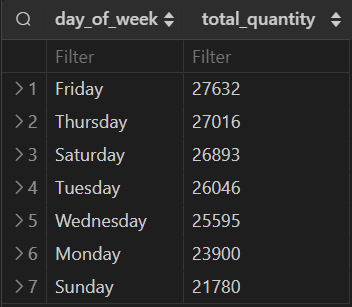

### Most Profitable Months of the Year

In [ ]:
SELECT 
    TO_CHAR(date_trunc('month', o.order_date::date), 'month') AS month,
    SUM(od.quantity) AS total_quantity,
    ROUND(SUM(od.total_price)) AS total_revenue
FROM 
    Orders AS o
JOIN 
    Order_Details AS od ON 
    o.order_id = od.order_id
GROUP BY 
    month
ORDER BY 
    total_revenue DESC;

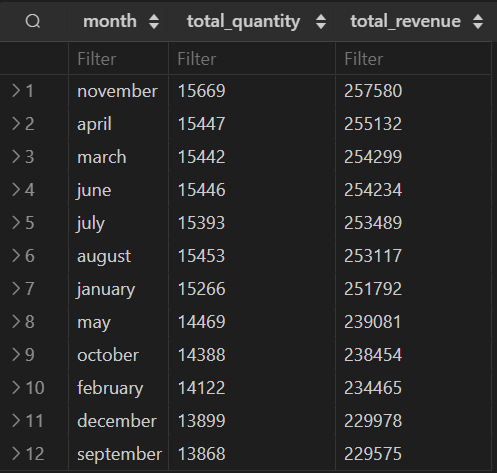
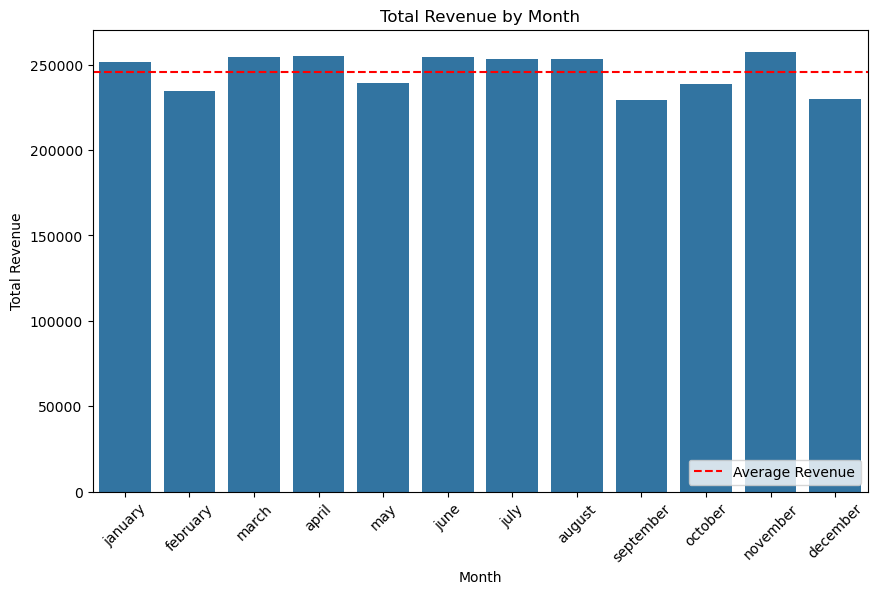

### Best-Performing Pizza Category

In [ ]:
SELECT 
    DISTINCT p.pizza_category,
    SUM(od.quantity) AS total_quantity,
    ROUND(SUM(od.total_price)) AS total_revenue
FROM 
    pizzas p
JOIN
    order_details od ON
    p.pizza_id = od.pizza_id
GROUP BY
    p.pizza_category
ORDER BY
    total_quantity DESC


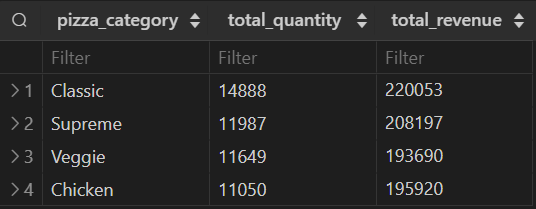

### Pizza Size Performance

In [ ]:
SELECT 
    DISTINCT p.pizza_size,
    SUM(od.quantity) AS total_quantity,
    ROUND(SUM(od.total_price)) AS total_revenue
FROM 
    pizzas p
JOIN
    order_details od ON
    p.pizza_id = od.pizza_id
GROUP BY
    p.pizza_size
ORDER BY
    total_quantity DESC

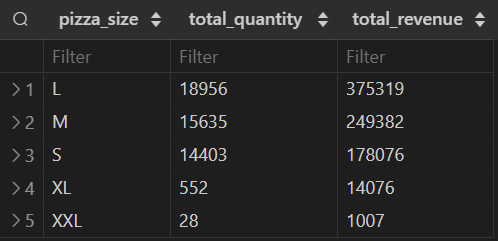

### Top 5 Orders by Total Price


In [ ]:
SELECT 
    order_id, 
    SUM(total_price) as sum_total_price
FROM 
    Order_details
GROUP BY 
    order_id
ORDER BY 
    sum_total_price DESC
LIMIT 5;

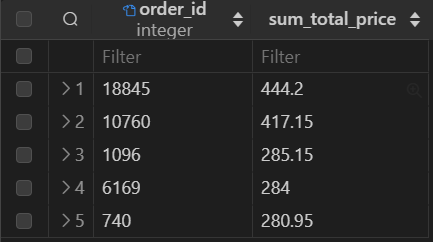

### Items Ordered in the Most Expensive Order

In [ ]:
SELECT 
    p.pizza_id,
    p.pizza_name,
    p.pizza_size,
    SUM(od.total_price) OVER(
        PARTITION BY p.pizza_id
    ) AS Pizza_price,
    SUM(od.total_price) OVER (
        PARTITION BY od.order_id 
        ORDER BY od.pizza_id
    ) AS Rolling_total,
    RANK() OVER(
        ORDER BY od.total_price DESC
    ) AS Price_rank
FROM 
    Pizzas p
JOIN 
    order_details od ON
    od.pizza_id = p.pizza_id
WHERE od.order_id = (
    SELECT order_id
    FROM Order_details
    GROUP BY order_id
    ORDER BY SUM(total_price) DESC
    LIMIT 1);

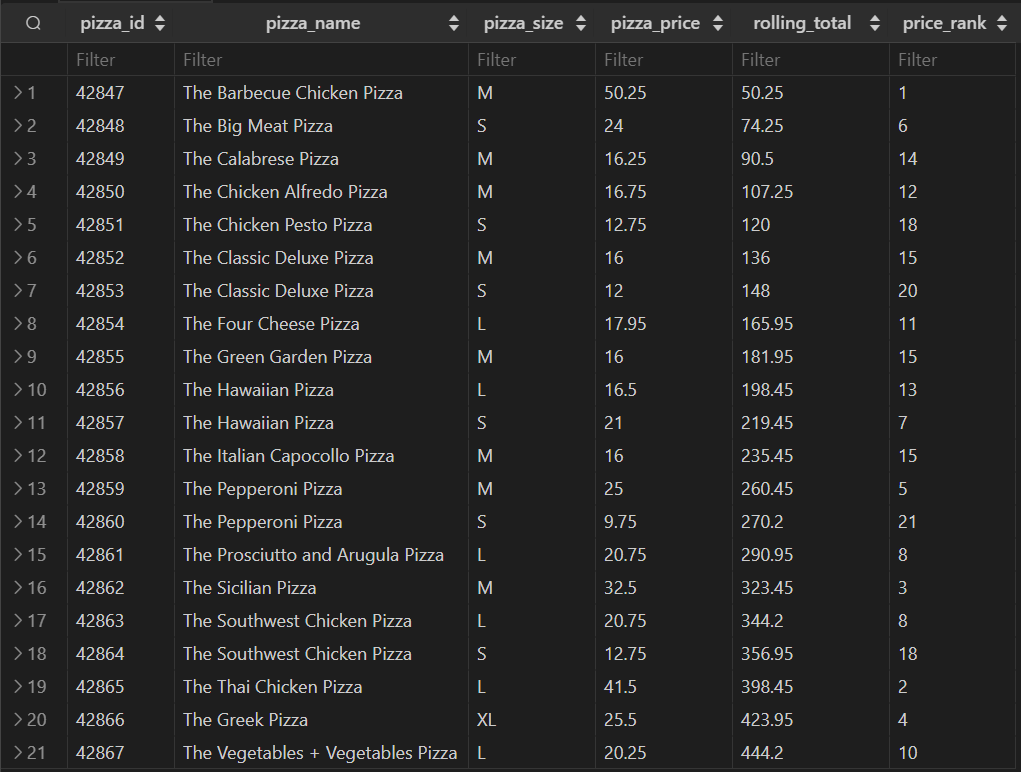